# 2024 Day 12

https://adventofcode.com/2024/day/12

https://adventofcode.com/2024/day/12/input

In [1]:
import re
from collections import namedtuple
from numbers import Number

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
test0 = """AAAA
BBCD
BBCC
EEEC"""

test1 = """OOOOO
OXOXO
OOOOO
OXOXO
OOOOO"""

test2 = """RRRRIICCFF
RRRRIICCCF
VVRRRCCFFF
VVRCCCJFFF
VVVVCJJCFE
VVIVCCJJEE
VVIIICJJEE
MIIIIIJJEE
MIIISIJEEE
MMMISSJEEE"""

text = open("input-12.txt").read().strip()

## EDA

In [3]:
def map2num(text):
    return np.array([[ord(c) - ord('A') for c in line] for line in text.split('\n')])   

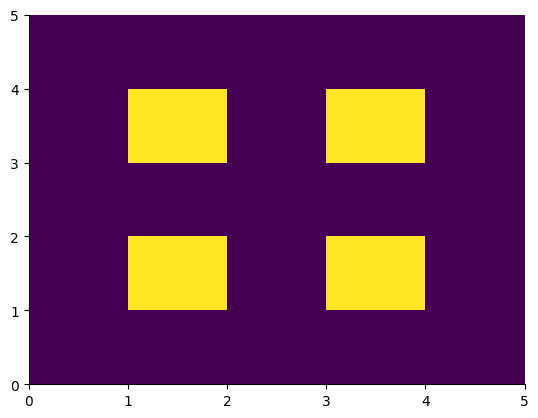

In [4]:
plt.pcolormesh(map2num(test1).T)

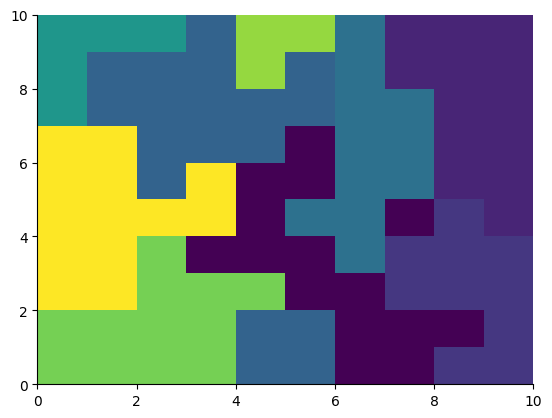

In [5]:
plt.pcolormesh(map2num(test2))

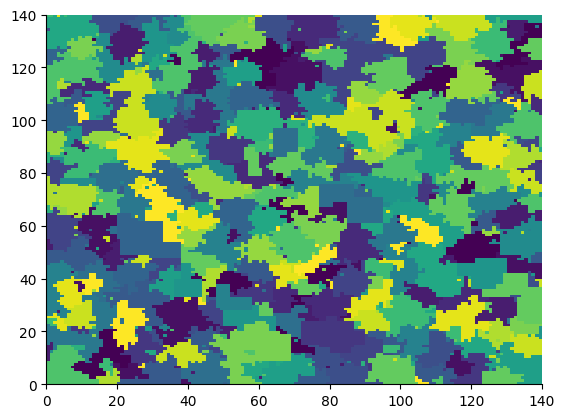

In [6]:
plt.pcolormesh(map2num(text))

## Data Structures

In [7]:
Loc = namedtuple("Loc", ["row", "col"])
Loc

__main__.Loc

In [8]:
def text_to_points(text) -> dict[str, set[Loc]]:
    out = {}
    for (row, line) in enumerate(text.strip().split('\n')):
        for (col, char) in enumerate(line):
            out.setdefault(char, set())
            out[char].add(Loc(row, col))
    return out

In [9]:
print(test0)

AAAA
BBCD
BBCC
EEEC


In [10]:
text_to_points(test0)

{'A': {Loc(row=0, col=0),
  Loc(row=0, col=1),
  Loc(row=0, col=2),
  Loc(row=0, col=3)},
 'B': {Loc(row=1, col=0),
  Loc(row=1, col=1),
  Loc(row=2, col=0),
  Loc(row=2, col=1)},
 'C': {Loc(row=1, col=2),
  Loc(row=2, col=2),
  Loc(row=2, col=3),
  Loc(row=3, col=3)},
 'D': {Loc(row=1, col=3)},
 'E': {Loc(row=3, col=0), Loc(row=3, col=1), Loc(row=3, col=2)}}

In [11]:
Step = namedtuple("Step", ["nrows", "ncols"])

all_steps = [
    Step(0, 1),
    Step(0, -1),
    Step(1, 0),
    Step(-1, 0),
]

all_steps

[Step(nrows=0, ncols=1),
 Step(nrows=0, ncols=-1),
 Step(nrows=1, ncols=0),
 Step(nrows=-1, ncols=0)]

In [12]:
def loc_step(loc, step):
    return Loc(loc.row + step.nrows, loc.col + step.ncols)

def loc_halfstep(loc, step):
    return Loc(loc.row + step.nrows / 2, loc.col + step.ncols / 2)

In [13]:
def get_blocks(points: set[Loc]) -> list[set[Loc]]:
    # start with copy to treat as mutable
    points = set(points)
    blocks = []
    
    # do as many flood fills as we need to
    while points:
        # arbitrarily start at upper left
        loc = min(points)
        queue = [loc]
        block = set()
        blocks.append(block)
        
        # work through queue till empty
        while queue:
            loc = queue.pop(0)
            if loc not in points:
                continue
                
            block.add(loc)
            points.remove(loc)
            
            for step in all_steps:
                maybe = loc_step(loc, step)
                if maybe in points:
                    queue.append(maybe)
                    
    return blocks

In [14]:
from typing import Sequence

In [15]:
def get_all_blocks(points_sets: Sequence[set[Loc]]) -> list[set[Loc]]:
    return sum((get_blocks(points) for points in points_sets), [])

In [16]:
def get_area(block: set[Loc]) -> int:
    return len(block)

def get_all_edges(block):
    edges = set()
    for loc in block:
        for step in all_steps:
            edge = loc_halfstep(loc, step)
            edges.add(edge)
    return edges

def get_internal_edges(block):
    block = list(block)
    edges = set()
    for i in range(len(block) - 1):
        for j in range(i + 1, len(block)):
            loc1, loc2 = block[i], block[j]
            drow = loc2[0] - loc1[0]
            dcol = loc2[1] - loc1[1]
            step = Step(drow, dcol)
            if step in all_steps:
                edge = loc_halfstep(loc1, step)
                edges.add(edge)
            
    return edges

def get_boundary(block):
    return get_all_edges(block) - get_internal_edges(block)

def get_perim(block):
    return len(get_boundary(block))

In [17]:
def get_num_sides(block):
    boundary = get_boundary(block)
    
    horizontals = {}
    verticals = {}
    for loc in boundary:
        if loc.col % 1 == 0:
            d, key = horizontals, loc.row
        else:
            d, key = verticals, loc.col
        d.setdefault(key, set())
        d[key].add(loc)
        
    num_adj = 0
    
    for horizontal in horizontals.values():
        points = sorted(horizontal)
        for (p1, p2) in zip(points[:-1], points[1:]):
            dcol = p2.col - p1.col
            test1 = loc_step(p1, Step(0.5, 0.5))
            test2 = loc_step(p1, Step(-0.5, 0.5))
            if dcol >= 2 or (test1 in boundary and test2 in boundary):
                continue
                
            num_adj += 1
                
    for vertical in verticals.values():
        points = sorted(vertical)
        for (p1, p2) in zip(points[:-1], points[1:]):
            drow = p2.row - p1.row
            test1 = loc_step(p1, Step(0.5, 0.5))
            test2 = loc_step(p1, Step(0.5, -0.5))
            if drow >= 2 or (test1 in boundary and test2 in boundary):
                continue
                
            num_adj += 1
                
    return len(boundary) - num_adj

## Validation

In [18]:
d = text_to_points(text)
bs = get_all_blocks(d.values())
# bs

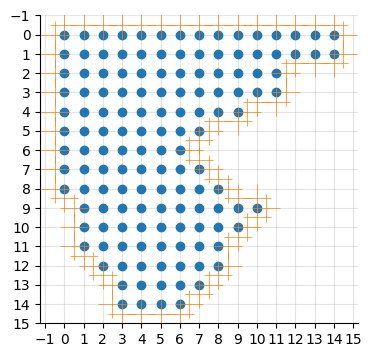

In [19]:
fig, ax = plt.subplots(figsize=(5, 4))

block = bs[0]
internal_edges = get_internal_edges(block)
boundary = get_boundary(block)

r, c = np.array(list(block)).T
ax.plot(c, r, 'o')
ax.set_ylim(reversed(ax.get_ylim()))
ax.set(yticks=np.arange(-1, r.max()+2), xticks=np.arange(-1, c.max()+2))

r, c = np.array(list(boundary)).T
ax.plot(c, r, '+', ms=20, mew=.5)

# r, c = np.array(list(internal_edges)).T
# ax.plot(c, r, '+', ms=3)

ax.set_aspect('equal')
ax.grid();

### Part 1 tests

In [20]:
blocks = get_all_blocks(text_to_points(test0).values())
sum(get_area(block) * get_perim(block) for block in blocks)

140

In [21]:
blocks = get_all_blocks(text_to_points(test1).values())
sum(get_area(block) * get_perim(block) for block in blocks)

772

In [22]:
blocks = get_all_blocks(text_to_points(test2).values())
sum(get_area(block) * get_perim(block) for block in blocks)

1930

### Part 2 tests

In [23]:
blocks = get_all_blocks(text_to_points(test0).values())
sum(get_area(block) * get_num_sides(block) for block in blocks)

80

In [24]:
blocks = get_all_blocks(text_to_points(test1).values())
sum(get_area(block) * get_num_sides(block) for block in blocks)

436

In [25]:
blocks = get_all_blocks(text_to_points(test2).values())
sum(get_area(block) * get_num_sides(block) for block in blocks)

1206

In [26]:
test3 = """EEEEE
EXXXX
EEEEE
EXXXX
EEEEE"""

test4 = """AAAAAA
AAABBA
AAABBA
ABBAAA
ABBAAA
AAAAAA"""

In [27]:
blocks = get_all_blocks(text_to_points(test3).values())
sum(get_area(block) * get_num_sides(block) for block in blocks)

236

In [28]:
blocks = get_all_blocks(text_to_points(test4).values())
sum(get_area(block) * get_num_sides(block) for block in blocks)

368

## Part 1

In [29]:
blocks = get_all_blocks(text_to_points(text).values())
sum(get_area(block) * get_perim(block) for block in blocks)

1473408

## Part 2

In [30]:
blocks = get_all_blocks(text_to_points(text).values())
sum(get_area(block) * get_num_sides(block) for block in blocks)

886364